In [1]:
# TODO: figure out a way to fix the missing frame errors

In [2]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.gridspec as gridspec

In [3]:
def getlabel(shWidth):
    if shWidth == int(shWidth):
        return str(int(shWidth))
    else:
        return str(shWidth).replace('.','p')

In [4]:
def correct_extra_frames (data):
    '''Sometimes, the code returns two frames per timestep instead of one, which results in incorrect time derivatives. Fortunately, this is easy to detect and correct, which we do here.'''
    for corr in data.keys():
        # 1) detect extra frames -- their sum of ddt values will be close to the average of their neighbours
        ddt_data = data[corr]['ddt_internal_energy']
        extra_frame_indices = np.where(np.array(
            [False,] + [
            np.abs(0.5*(ddt_data[i-1] + ddt_data[i+2]) - (ddt_data[i]+ddt_data[i+1])) < 0.05*(ddt_data[i-1] + ddt_data[i+2]) for i in np.arange(1,len(ddt_data)-2)
            ] + [False, False]
        ))
        for idx in extra_frame_indices:
            # 2) in ddt_data replace the first of the extra frames with their sum
            data[corr]['ddt_internal_energy'][idx] += data[corr]['ddt_internal_energy'][idx+1]
            # 3) remove the second of the extra frames from all quantities
            for key in ['ddt_internal_energy', 'flux_density']:
                data[corr][key] = np.delete(data[corr][key], idx+1)
            # 4) correct the time step array
            while(len(data[corr]['times']) > len(data[corr]['ddt_internal_energy'])):
                data[corr]['times'] = data[corr]['times'][:-1]
    return data

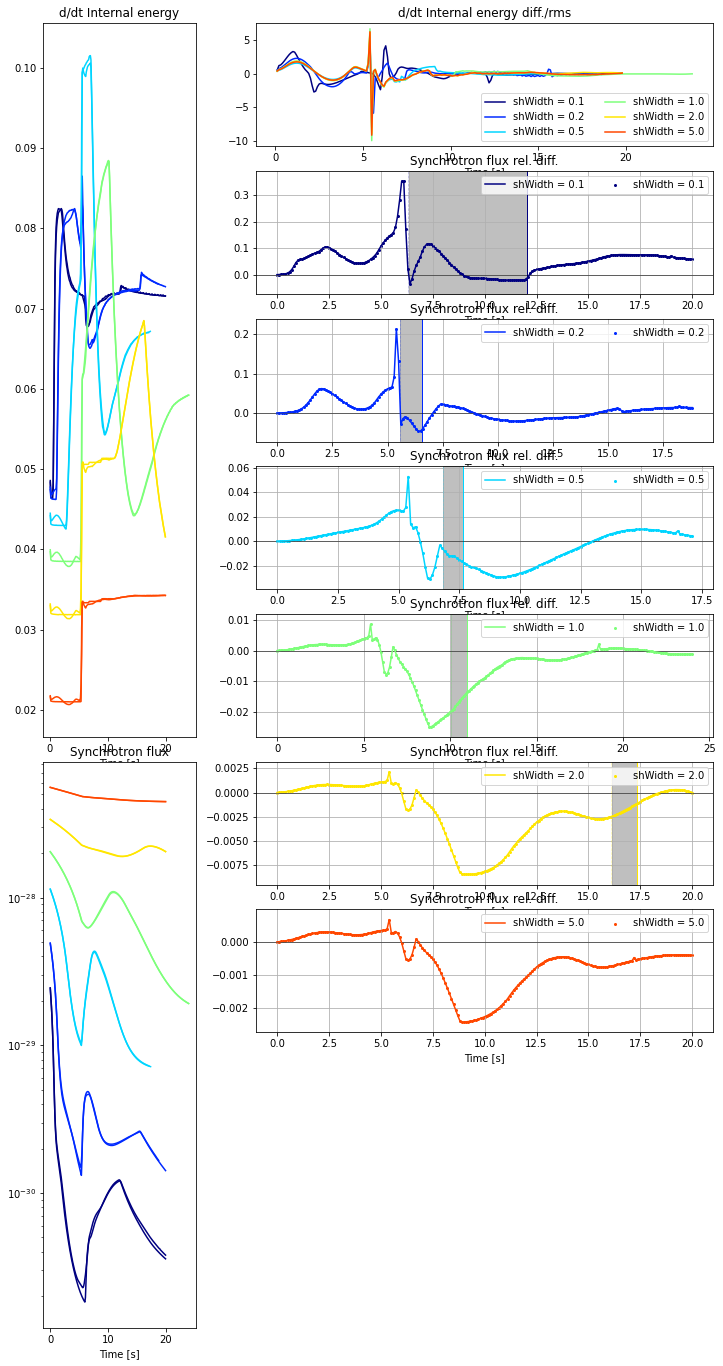

In [5]:
shWidths = [0.1, 0.2, 0.5, 1, 2, 5]#, 10]
n_shWidth = len(shWidths)

colors = {shWidths[i]:mplcm.jet(1.0*i/n_shWidth) for i in range(n_shWidth)}
linestyles = {0:':', 1:'-'}

fig = plt.figure(figsize=(12,24))
gs = gridspec.GridSpec(9,2, width_ratios=[1,3])

# read in the data
for shWidth in shWidths:
    data = {}
    for corr in [0,1]:
        with open('/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/prod2_shell_width/history_corr%ishWidth%s.pkl' % (corr, getlabel(shWidth)), 'rb') as f:
            data[corr] = pkl.load(f)
            
        # missing frame error for shW=5, limit to t < 17.5
        if shWidth == 0.5:
            mask = (data[corr]['times'] < 17.5)
            for key in ['times', 'ddt_internal_energy', 'flux_density']:
                data[corr][key] = data[corr][key][mask]
    
    # correct extra frames
    data = correct_extra_frames (data)

    # d/dt Internal energy ---------------------------------------

    plt.subplot(gs[0:5,0])
        
    plt.plot(data[0]['times'][:-1], data[0]['ddt_internal_energy'][:-1], color=colors[shWidth], ls=linestyles[corr])
    plt.plot(data[1]['times'][:-1], data[1]['ddt_internal_energy'][:-1], color=colors[shWidth], ls=linestyles[corr], label=('shWidth = %.1f' % shWidth))

    #plt.legend(ncol=2)
    plt.xlabel('Time [s]')
    plt.title('d/dt Internal energy')

    # d/dt Internal energy difference -----------------------------
    plt.subplot(gs[0,1])
    
    minlen = min(len(data[0]['ddt_internal_energy']), len(data[1]['ddt_internal_energy']))
    difference = data[1]['ddt_internal_energy'][:(minlen-2)] - data[0]['ddt_internal_energy'][:(minlen-2)]
    #average = 0.5 * (data[1]['ddt_internal_energy'][:-1] + data[0]['ddt_internal_energy'][:-1])
    rms = np.sqrt(np.nanmean(difference**2))
    plt.plot(data[0]['times'][:(minlen-2)], difference/rms, color=colors[shWidth], ls=linestyles[corr], label=('shWidth = %.1f' % shWidth))

    plt.legend(ncol=2)
    plt.xlabel('Time [s]')
    plt.title('d/dt Internal energy diff./rms')

    # Synchrotron flux ------------------------------------------
    
    plt.subplot(gs[5:,0])
        
    plt.plot(data[0]['times'], data[0]['flux_density'], color=colors[shWidth], ls=linestyles[corr])
    plt.plot(data[1]['times'], data[1]['flux_density'], color=colors[shWidth], ls=linestyles[corr], label=('shWidth = %.1f' % shWidth))
        
    plt.gca().set_yscale('log')
    #plt.legend(ncol=1)
    plt.xlabel('Time [s]')
    plt.title('Synchrotron flux')

    # Times of collision start and peak emission --------------------------------

    plt.subplot(gs[1+shWidths.index(shWidth),1])

    time_start = []
    time_peak = []
    for corr in [0,1]:
            
        df = data[corr]['flux_density'][1:] - data[corr]['flux_density'][:-1]
        dt = data[corr]['times'][1:] - data[corr]['times'][:-1]
        tavg = 0.5*(data[corr]['times'][1:] + data[corr]['times'][:-1])

        dfdt = df/dt
        idx_start = np.argmax(dfdt)
        time_start.append(data[corr]['times'][idx_start])

        d_dfdt = dfdt[(idx_start+1):] * dfdt[idx_start:-1]
        indices = np.where(d_dfdt < 0)[0]
        if len(indices) > 0:
            idx_peak = idx_start + indices[0]
            time_peak.append(0.5 * (tavg[idx_peak] + tavg[idx_peak+1]))
        
        del df, dt, dfdt, d_dfdt
    
    if len(time_start) > 0 and len(time_peak) > 0:
        plt.fill_between(tavg, 0,1, where=((tavg >= np.mean(time_start)) & (tavg <= np.mean(time_peak))), transform=plt.gca().get_xaxis_transform(), color='grey', alpha=0.5)
        plt.axvline(np.mean(time_start), color=colors[shWidth], linewidth=0.5, linestyle=":")
        plt.axvline(np.mean(time_peak),  color=colors[shWidth], linewidth=1.0, linestyle="-")
    
    #plt.ylim(-0.1,0.4)
    plt.axhline(0., color='k', linewidth=0.5)
    plt.grid(True)

    # Synchrotron flux difference --------------------------------
    
    plt.subplot(gs[1+shWidths.index(shWidth),1])
    
    minlen = min(len(data[0]['flux_density']), len(data[1]['flux_density']))
    difference = data[1]['flux_density'][:minlen] - data[0]['flux_density'][:minlen]
    average = 0.5 * (data[1]['flux_density'][:minlen] + data[0]['flux_density'][:minlen])
    
    plt.plot(data[0]['times'][:minlen], difference/average, color=colors[shWidth], ls=linestyles[corr], label=('shWidth = %.1f' % shWidth))
    plt.scatter(data[0]['times'][:minlen], difference/average, color=colors[shWidth], ls=linestyles[corr], label=('shWidth = %.1f' % shWidth), s=4)
    
    mini, maxi = np.min(difference/average), np.max(difference/average)
    difference = maxi - mini
    mini, maxi = mini - 0.1*difference, maxi + 0.1*difference
    plt.ylim(mini, maxi)

    plt.legend(ncol=2)
    plt.xlabel('Time [s]')
    plt.title('Synchrotron flux rel. diff.')

if False:
    plt.savefig('pencil_shWidths.png', format='png', dpi=600)
else:
    plt.show()
plt.close()

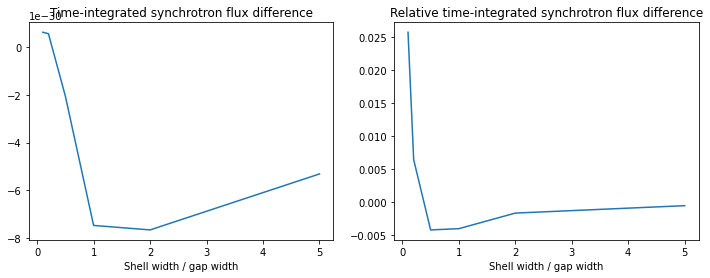

In [6]:
# Integrated net Synchrotron flux difference --------------------------------
synchro_diff_tot = {}
synchro_mean_tot = {}
for shWidth in shWidths:
    data = {}
    for corr in [0,1]:
        with open('/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/prod2_shell_width/history_corr%ishWidth%s.pkl' % (corr, getlabel(shWidth)), 'rb') as f:
            data[corr] = pkl.load(f)
            
        # missing frame error for shW=5, limit to t < 17.5
        if shWidth == 0.5:
            mask = (data[corr]['times'] < 17.5)
            for key in ['times', 'ddt_internal_energy', 'flux_density']:
                data[corr][key] = data[corr][key][mask]
    
    # correct extra frames
    data = correct_extra_frames (data)
            
    minlen = min(len(data[0]['flux_density']),len(data[1]['flux_density']))
            
    total_emission = 0.5 * (data[1]['flux_density'][:minlen] + data[0]['flux_density'][:minlen])
    total_emission = 0.5 * (total_emission[1:] + total_emission[:-1])
    
    difference = data[1]['flux_density'][:minlen] - data[0]['flux_density'][:minlen]
    difference = 0.5 * (difference[1:] + difference[:-1])
    
    tt = data[0]['times'][:minlen]
    dt = tt[1:] - tt[:-1]
    
    synchro_diff_tot[shWidth] = np.sum(difference*dt)
    synchro_mean_tot[shWidth] = np.sum(total_emission*dt)
    
    del data
    
# plot

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(synchro_diff_tot.keys(), synchro_diff_tot.values())
plt.xlabel('Shell width / gap width')
plt.title('Time-integrated synchrotron flux difference')
    
plt.subplot(122)
plt.plot(synchro_diff_tot.keys(), np.array(list(synchro_diff_tot.values())) / np.array(list(synchro_mean_tot.values())))
plt.xlabel('Shell width / gap width')
plt.title('Relative time-integrated synchrotron flux difference')

plt.show()
plt.close()

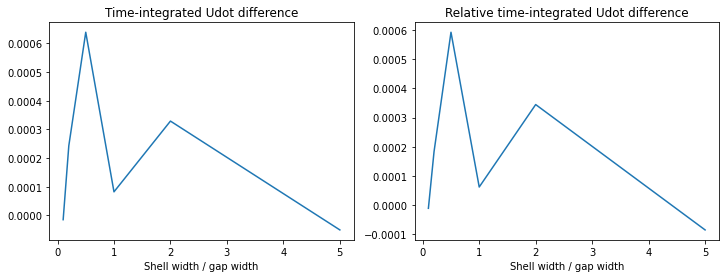

In [7]:
# Integrated net Internal energy time derivative difference --------------------------------
Udot_diff_tot = {}
Udot_mean_tot = {}
for shWidth in shWidths:
    data = {}
    for corr in [0,1]:
        with open('/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/prod2_shell_width/history_corr%ishWidth%s.pkl' % (corr, getlabel(shWidth)), 'rb') as f:
            data[corr] = pkl.load(f)
            
        # missing frame error for shW=5, limit to t < 17.5
        if shWidth == 0.5:
            mask = (data[corr]['times'] < 17.5)
            for key in ['times', 'ddt_internal_energy', 'flux_density']:
                data[corr][key] = data[corr][key][mask]
    
    # correct extra frames
    data = correct_extra_frames (data)
            
    minlen = min(len(data[0]['ddt_internal_energy']), len(data[1]['ddt_internal_energy']))
            
    total_Udot = 0.5 * (data[1]['ddt_internal_energy'][1:(minlen-2)] + data[0]['ddt_internal_energy'][1:(minlen-2)])
    total_Udot = 0.5 * (total_Udot[1:] + total_Udot[:-1])
        
    difference = data[1]['ddt_internal_energy'][1:(minlen-2)] - data[0]['ddt_internal_energy'][1:(minlen-2)]
    difference = 0.5 * (difference[1:] + difference[:-1])
    
    dt = data[0]['times'][3:(minlen-1)] - data[0]['times'][2:(minlen-2)]
    
    Udot_diff_tot[shWidth] = np.sum(difference*dt)
    Udot_mean_tot[shWidth] = np.sum(total_Udot*dt)
    
    del data
    
# plot

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(Udot_diff_tot.keys(), Udot_diff_tot.values())
plt.xlabel('Shell width / gap width')
plt.title('Time-integrated Udot difference')
    
plt.subplot(122)
plt.plot(Udot_diff_tot.keys(), np.array(list(Udot_diff_tot.values())) / np.array(list(Udot_mean_tot.values())))
plt.xlabel('Shell width / gap width')
plt.title('Relative time-integrated Udot difference')

plt.show()
plt.close()

------------------------
**Plots for Paper 1**

In [8]:
import matplotlib
matplotlib.rcParams.update({'font.size': 6})

paper1_savepath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/Paper1/plots/'

In [9]:
# constants
from astropy.constants import e, c, m_e
import astropy.units as u
from scipy.special import gamma
e = e.esu.value * u.cm**1.5 * u.g**0.5 / u.s

#constants
e = e.cgs.value
c = c.cgs.value
m_e = m_e.cgs.value
#units
cm = 1.0
gram = 1.0
sec = 1.0
Hz = 1.0
kpc = (1.*u.kpc).cgs.value
Msun = (1.*u.Msun).cgs.value
erg = (1.*u.erg).cgs.value
def get_cgs (x): return x
def get_cgs_value (x): return x
    
# simulation units
# anchor points
simu_rho = get_cgs(10**(-15) * gram/cm**3)
simu_t = get_cgs(1.*sec)
simu_len = get_cgs(c*simu_t)
# derivative units
simu_mass = get_cgs(simu_rho * simu_len**3)
simu_en = simu_mass * get_cgs(c)**2 # erg
simu_press = simu_en / simu_len**3 # erg / cm^3
simu_B = np.sqrt(2.*simu_press) # sqrt( erg / cm^3 )
simu_B_8piCorr = np.sqrt(8.*np.pi*simu_press) # sqrt( erg / cm^3 )

In [10]:
sim2phys = {
    'Time':simu_t, # sec
    'x1f':simu_len, # cm
    'x2f':simu_len, # cm
    'x3f':simu_len, # cm
    'x1v':simu_len, # cm
    'x2v':simu_len, # cm
    'x3v':simu_len, # cm
    'rho':simu_mass/simu_len**3, # g / cm^3
    'press':simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'vel1': 1.0, # c
    'vel2': 1.0, # c
    'vel3': 1.0, # c
    'vel_tot': 1.0, # c
    'Bcc1': simu_B, # sqrt(erg / cm^3)
    'Bcc2': simu_B, # sqrt(erg / cm^3)
    'Bcc3': simu_B, # sqrt(erg / cm^3)
    'Bcc_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_0': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_1': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_2': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_3': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot_vsZ': simu_B, # sqrt(erg / cm^3)
    'enthalpy': simu_mass * (simu_len/simu_t)**2 / simu_mass, # erg/g
    'internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'j_nu': 1.0, # erg / cm**3
    'j_nu_vsZ': 1.0, # erg / cm**3
    'j_over_alpha_nu': 1.0, # erg / cm**2
    'j_over_alpha_nu_vsZ': 1.0, # erg / cm**2
    'flux_density': 1.0, # erg/(cm**2*sec) / cm**2
    'flux_density_vsZ': 1.0, # erg/(cm**2*sec) / cm**2
    'spectrum': (1.0, 1.0), # (Hz, erg / (s cm**2 Hz) / cm**2)
    'ddt_internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
    'ddt_internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
}

In [28]:
shWidths = [0.1, 0.2, 0.5, 1, 2] #, 5]#, 10]
n_shWidth = len(shWidths)

colors = {shWidths[i]:mplcm.jet(1.0*i/n_shWidth) for i in range(n_shWidth)}
linestyles = {0:':', 1:'-'}

fig = plt.figure(figsize=(7,8.5))
gs = gridspec.GridSpec(7,2, height_ratios=[1,0.15,1,1,1,1,1], width_ratios=[1,3])

# read in the data
for shWidth in shWidths:
    data = {}
    for corr in [0,1]:
        with open('/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/prod2_shell_width/history_corr%ishWidth%s.pkl' % (corr, getlabel(shWidth)), 'rb') as f:
            data[corr] = pkl.load(f)
            
        # missing frame error for shW=5, limit to t < 17.5
        if shWidth == 0.5:
            mask = (data[corr]['times'] < 17.5)
            for key in ['times', 'ddt_internal_energy', 'flux_density']:
                data[corr][key] = data[corr][key][mask]
    
    # correct extra frames
    data = correct_extra_frames (data)

    # d/dt Internal energy ---------------------------------------

    plt.subplot(gs[0:4,0])
        
    #plt.plot(data[0]['times'][:-1], data[0]['ddt_internal_energy'][:-1], color=colors[shWidth], ls=linestyles[corr])
    plt.plot(
        data[1]['times'][:-1] * sim2phys['Time'],
        data[1]['ddt_internal_energy'][:-1] * sim2phys['ddt_internal_energy'] * 1.0e-4,
        color=colors[shWidth], ls=linestyles[corr],
        label=('shWidth = %.1f' % shWidth)
    )

    #plt.legend(ncol=2)
    #plt.xlabel('Time [s]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('d/dt( Internal energy ) [$10^4$erg $/$ (cm$^3$ s)]')
    plt.text(0.8,0.94, '(a)', transform=plt.gca().transAxes)

    # d/dt Internal energy difference -----------------------------
    plt.subplot(gs[0,1])
    
    minlen = min(len(data[0]['ddt_internal_energy']), len(data[1]['ddt_internal_energy']))
    difference = data[1]['ddt_internal_energy'][:(minlen-2)] - data[0]['ddt_internal_energy'][:(minlen-2)]
    #average = 0.5 * (data[1]['ddt_internal_energy'][:-1] + data[0]['ddt_internal_energy'][:-1])
    rms = np.sqrt(np.nanmean(difference**2))
    plt.plot(
        data[0]['times'][:(minlen-2)],
        difference/rms,
        color=colors[shWidth],
        ls=linestyles[corr],
        label=('width = %.1f' % shWidth)
    )

    plt.legend(ncol=2)
    plt.xlabel('Time [s]')
    plt.title('d/dt( Internal energy difference ) / rms')
    plt.text(0.05,0.2, '(c)', transform=plt.gca().transAxes)

    # Synchrotron flux ------------------------------------------
    
    plt.subplot(gs[4:,0])
        
    #plt.plot(data[0]['times'], data[0]['flux_density'], color=colors[shWidth], ls=linestyles[corr])
    plt.plot(
        data[1]['times'] * sim2phys['Time'],
        data[1]['flux_density'] * sim2phys['flux_density'],
        color=colors[shWidth],
        ls=linestyles[corr],
        label=('shWidth = %.1f' % shWidth)
    )
        
    plt.gca().set_yscale('log')
    #plt.legend(ncol=1)
    plt.xlabel('Time [s]')
    plt.ylabel('d/dS( Synchrotron flux ) [${\\rm erg}/({\\rm cm}^2{\\rm s}) / {\\rm cm}^2$]')
    plt.text(0.8,0.94, '(b)', transform=plt.gca().transAxes)

    # Times of collision start and peak emission --------------------------------

    plt.subplot(gs[2+shWidths.index(shWidth),1])

    time_start = []
    time_peak = []
    for corr in [0,1]:
            
        df = data[corr]['flux_density'][1:] - data[corr]['flux_density'][:-1]
        dt = data[corr]['times'][1:] - data[corr]['times'][:-1]
        tavg = 0.5*(data[corr]['times'][1:] + data[corr]['times'][:-1])

        dfdt = df/dt
        idx_start = np.argmax(dfdt)
        time_start.append(data[corr]['times'][idx_start])

        d_dfdt = dfdt[(idx_start+1):] * dfdt[idx_start:-1]
        indices = np.where(d_dfdt < 0)[0]
        if len(indices) > 0:
            idx_peak = idx_start + indices[0]
            time_peak.append(0.5 * (tavg[idx_peak] + tavg[idx_peak+1]))
        
        del df, dt, dfdt, d_dfdt
    
    if len(time_start) > 0 and len(time_peak) > 0:
        plt.fill_between(tavg, 0,1, where=((tavg >= np.mean(time_start)) & (tavg <= np.mean(time_peak))), transform=plt.gca().get_xaxis_transform(), color='grey', alpha=0.5)
        #plt.axvline(np.mean(time_start), color=colors[shWidth], linewidth=0.5, linestyle=":")
        #plt.axvline(np.mean(time_peak),  color=colors[shWidth], linewidth=1.0, linestyle="-")
    
    #plt.ylim(-0.1,0.4)
    plt.axhline(0., color='k', linewidth=0.5)
    plt.grid(True)

    # Synchrotron flux difference --------------------------------
    
    plt.subplot(gs[2+shWidths.index(shWidth),1])
    
    minlen = min(len(data[0]['flux_density']), len(data[1]['flux_density']))
    difference = data[1]['flux_density'][:minlen] - data[0]['flux_density'][:minlen]
    average = 0.5 * (data[1]['flux_density'][:minlen] + data[0]['flux_density'][:minlen])
    
    plt.plot(data[0]['times'][:minlen], difference/average, color=colors[shWidth], ls=linestyles[corr], label=('shWidth = %.1f' % shWidth))
    plt.scatter(data[0]['times'][:minlen], difference/average, color=colors[shWidth], ls=linestyles[corr], label=('shWidth = %.1f' % shWidth), s=4)
    
    mini, maxi = np.min(difference/average), np.max(difference/average)
    difference = maxi - mini
    mini, maxi = mini - 0.1*difference, maxi + 0.1*difference
    plt.ylim(mini, maxi)

    #plt.legend(ncol=2)
    if shWidth != shWidths[-1]:
        plt.gca().axes.xaxis.set_ticklabels([])
    else:
        plt.xlabel('Time [s]')
    if shWidth == shWidths[0]:
        plt.title('d/dS( Synchrotron flux ), relative difference')
    plt.text(0.07,0.72, '(d%i)' % (shWidths.index(shWidth)+1,), transform=plt.gca().transAxes)

if True:
    plt.subplots_adjust(left=0.07, bottom=0.04, right=0.95, top=0.97)
    plt.savefig(paper1_savepath + 'pencil_shWidths.png', format='png', dpi=600)
else:
    plt.show()
plt.close()